# 2 Data Wrangling<a id='2_Data_Wrangling'></a>
Justin Jimenez 11/20/2021

The objective of this notebook is to collect and clean the data in preparation for EDA.

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Data Wrangling Preparation](#2.2_Data_Wrangling_Preparation)
      * [2.2.1 Imports](#2.2.1_Imports)
      * [2.2.2 Load Loan Data](#2.2.2_Load_Loan_Data)
      * [2.2.3 Target Response Feature](#2.2.3_Target_Response_Feature)
  * [2.3 Cleaning Data](#2.3_Cleaning_Data)
      * [2.3.1 Missing Values](#2.3.1_Missing_Values)
      * [2.3.2 Removing Outliers With IQR](#2.3.2_Removing_Outliers_With_IQR)
      * [2.3.3 Drop Useless Features](#2.3.3_Drop_Useless_Features)
      * [2.3.4 Checking For Duplicates](#2.3.4_Checking_For_Duplicates)
      * [2.3.5 Imputing With Median Values](#2.3.5_Imputing_With_Median_Values)      
      * [2.3.6 Changing Data Types](#2.3.6_Changing_Data_Types)
          * [2.3.6.1 Loan Terms](#2.3.6.1_Loan_Terms)
          * [2.3.6.2 Interest Rate](#2.3.6.2_Interest_Rate)
          * [2.3.6.3 Categories, Strings, and Datetime](#2.3.6.3_Categories_Strings_And_Datetime)
          * [2.3.6.4 Integers](#2.3.6.4_Integers)

## 2.2 Data Wrangling Preparation<a id='2.2_Data_Wrangling_Preparation'></a>
### 2.2.1 Imports<a id='2.2.1_Imports'></a>

I imported pandas, matplotlib, bamboolib, and missingno. Pandas was for importing and organizing the data. Matplotlib and missingno were for visualizing the data. Bamboolib was used to make it easy to manipulate the data.

In [1]:
import sys
sys.executable

'C:\\Users\\jjsun\\anaconda3\\python.exe'

In [2]:
!jupyter kernelspec list --json

{
  "kernelspecs": {
    "python3": {
      "resource_dir": "C:\\Users\\jjsun\\anaconda3\\share\\jupyter\\kernels\\python3",
      "spec": {
        "argv": [
          "C:/Users/jjsun/anaconda3\\python.exe",
          "-m",
          "ipykernel_launcher",
          "-f",
          "{connection_file}"
        ],
        "env": {},
        "display_name": "Python 3",
        "language": "python",
        "interrupt_mode": "signal",
        "metadata": {}
      }
    }
  }
}


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import bamboolib as bam
import missingno as msno

### 2.2.2 Load the Loan Data<a id='2.2.2_Load_Loan_Data'></a>
After importing the necessary libraries, I extracted the data from a gzip file downloaded from https://www.kaggle.com/faressayah/lending-club-loan-defaulters-prediction/data.

In [4]:
loan_data = pd.read_csv(r'C:\Users\jjsun\OneDrive\Desktop\pythonprojects\LendingClub-Loan_Default-Prediction\data\raw\Loan_status_2007-2020Q3.gzip')
loan_data_dict = pd.read_excel(r'C:\Users\jjsun\OneDrive\Desktop\pythonprojects\LendingClub-Loan_Default-Prediction\data\raw\LCDataDictionary.xlsx')

The following DataFrame can be used to understand the feature names in loan_data.

In [5]:
# loan_data_dict

In [6]:
# print([column for column in df_scan.columns])
# features = [feature for feature in df_scan.columns if feature not in ['Unnamed: 0', 'id']]
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


Loading in the loan data showed that there were almost three million observations and 142 features. Thirty-five of the columns were categorical (object type) and 107 columns were numerical (float64 and int 64).

I took a preliminary inspection of the features using the bamboolib UI. Run the cell below, startup the bamboolib UI, and select "Explore DataFrame".

In [7]:
# loan_data

### 2.2.3 Target Response Feature<a id='2.2.3_Target_Response_Feature'></a>

Looking at the primary target response feature - loan status - I saw that nearly 400,000 P2P loans have been charged off across thirteen years and 3 million loans. An inspection of missingness for this feature in bamboolib revealed only 1 observation that is missing a loan status.

<AxesSubplot:>

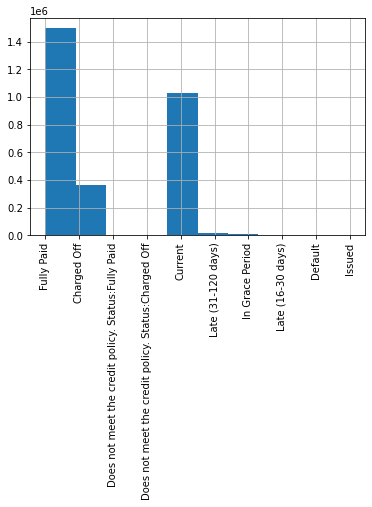

In [8]:
loan_data['loan_status'].hist(xrot = 90)

I am also interested in the credit scores of debtors to identify any relationship between credit scores and interest rates. Looking at the distribution of FICO scores reveals that most debtors have a score between 650-750.

<AxesSubplot:>

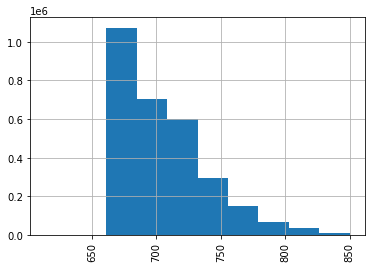

In [9]:
loan_data['fico_range_high'].hist(xrot = 90)

I held off on looking at the distribution of interest rates for now since that feature is incorrectly formatted as text instead of float data.

## 2.3 Cleaning Data<a id='2.3_Cleaning_Data'></a>
### 2.3.1 Missing Values<a id='2.3.1_Missing_Values'></a>

Since the dataset is quite large, I identified features that have high missingness to narrow the focus of the project.

Inspecting the missingness percentage of each feature revealed several features that were missing data for nearly all of the observations.

In [10]:
missing = pd.concat([loan_data.isnull().sum().sort_values(ascending = False), 100 * loan_data.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
print(missing)

                        count          %
hardship_loan_status  2782082  95.097886
hardship_reason       2781861  95.090332
hardship_status       2781858  95.090229
hardship_dpd          2781856  95.090161
hardship_type         2781855  95.090127
...                       ...        ...
last_fico_range_low         1   0.000034
policy_code                 1   0.000034
funded_amnt                 1   0.000034
id                          0   0.000000
Unnamed: 0                  0   0.000000

[142 rows x 2 columns]


I arbitrarily choose 60% missingness as the cutoff point and dropped any irrelevant features over that threshold.

In [11]:
missing_over60 = missing[missing['%'] > 60].index
loan_data = loan_data.drop(columns=missing_over60)

Once that was done, I used missingno's matrix to visualize patterns across all features for all observations.

<AxesSubplot:>

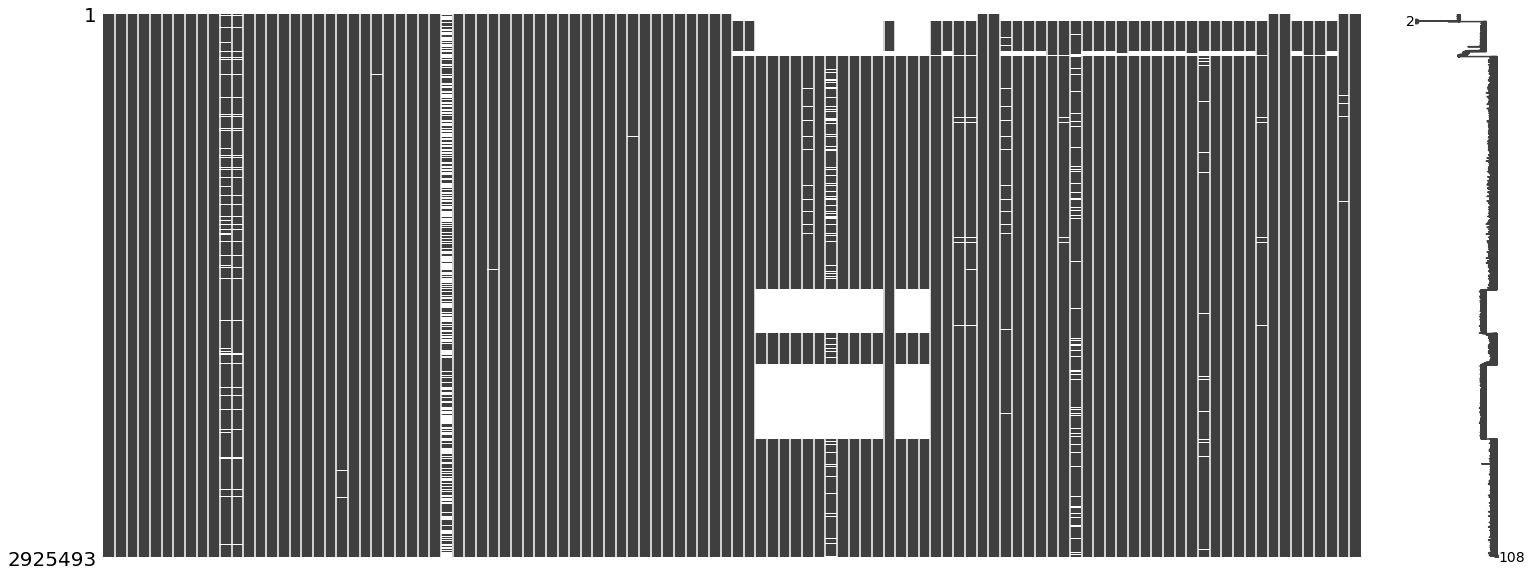

In [12]:
msno.matrix(loan_data)

This reveals several observations (29.6% according to bamboolib) that are missing data at random for several features. I dropped these observations by subsetting on one of the features that these observations were missing data on. I also filled some missing data for categorical features with categories that imply missingness. This produced a dramatic improvement in the missingness of the data.

<AxesSubplot:>

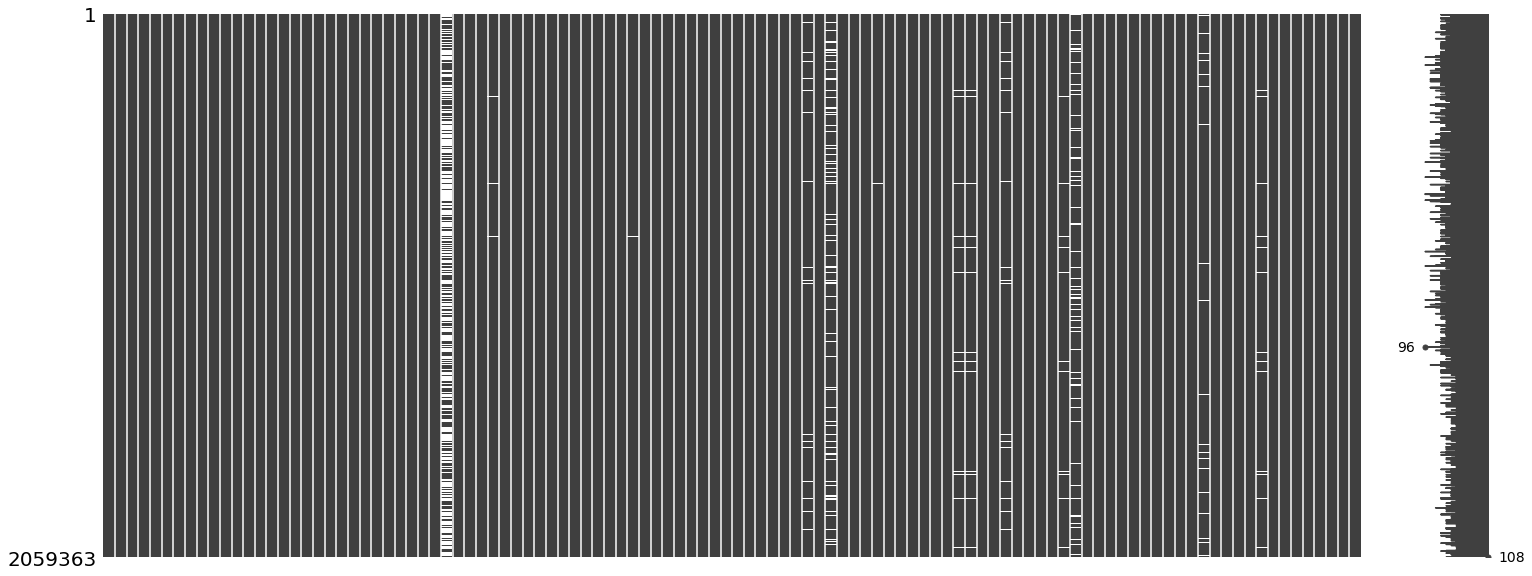

In [13]:
# Drop NA by subsetting on a feature that is frequently missing.
loan_data = loan_data.dropna(subset=['inq_fi'])

# Fill missing categorical data
loan_data[['emp_title']] = loan_data[['emp_title']].fillna('No Employment')
loan_data[['emp_length']] = loan_data[['emp_length']].fillna('No Employment')
loan_data[['title']] = loan_data[['title']].fillna('No Title')
loan_data[['zip_code']] = loan_data[['zip_code']].fillna(loan_data[['zip_code']].mode().iloc[0])
loan_data[['hardship_flag']] = loan_data[['hardship_flag']].fillna(loan_data[['hardship_flag']].mode().iloc[0])

#Visualize remaining missingness
msno.matrix(loan_data)

Below you will find a list of the remaining features with missing data. Some of these observations were dropped since they represented a relatively small fraction of the total observations. Observations that were missing data on the "Months Since Recent Inquiry" (11.53% missing) were also dropped.

In [14]:
missing = pd.concat([loan_data.isnull().sum().sort_values(ascending = False), 100 * loan_data.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
print(missing[missing['count']>0])

                          count          %
mths_since_last_delinq  1092416  53.046306
il_util                  291019  14.131506
mths_since_recent_inq    237439  11.529730
num_tl_120dpd_2m          64961   3.154422
mths_since_rcnt_il        60400   2.932946
mo_sin_old_il_acct        60400   2.932946
bc_util                   25874   1.256408
percent_bc_gt_75          25008   1.214356
bc_open_to_buy            24904   1.209306
mths_since_recent_bc      23492   1.140741
last_pymnt_d               4268   0.207249
dti                        3107   0.150872
revol_util                 2169   0.105324
all_util                    356   0.017287
avg_cur_bal                 100   0.004856
last_credit_pull_d           28   0.001360
pct_tl_nvr_dlq                2   0.000097
inq_last_12m                  1   0.000049
total_cu_tl                   1   0.000049
inq_last_6mths                1   0.000049
open_acc_6m                   1   0.000049


In [15]:
# Drop observations by feature for features with missingness less than 4%
loan_data = loan_data.dropna(subset=['num_tl_120dpd_2m', 'dti', 'all_util', 'mo_sin_old_il_acct', 'total_cu_tl', 
                                     'last_credit_pull_d', 'last_pymnt_d', 'percent_bc_gt_75', 'revol_util'])
# Drop observations that are missing data for the "Months Since Recent Inquiry" feature
loan_data = loan_data.dropna(subset=['mths_since_recent_inq'])

Before I imputed the remaining missing values, I checked for outliers and duplicates to remove.

### 2.3.2 Removing Outliers with IQR<a id='2.3.2_Removing_Outliers_With_IQR'></a>
I opted to filter outliers with an interquartile range approach. The function below was sourced from this question on stackoverflow: https://stackoverflow.com/questions/46245035/pandas-dataframe-remove-outliers

In [16]:
# Sourced from https://stackoverflow.com/questions/46245035/pandas-dataframe-remove-outliers
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [17]:
outliers = Remove_Outlier_Indices(loan_data.select_dtypes(include = 'float'))
for column in outliers.columns:
    outliers.drop(index = outliers[~outliers[column]].index)

In [18]:
loan_data = loan_data[loan_data.index == outliers.index]

### 2.3.3 Drop Useless Features<a id='2.3.3_Drop_Useless_Features'></a>
There are some features that were unnecessary and irrelevant, so I dropped them.

In [19]:
loan_data = loan_data.drop(columns=['id', 'Unnamed: 0', 'issue_d', 'pymnt_plan', 'url', 'title'])

### 2.3.4 Checking For Duplicates<a id='2.3.4_Checking_For_Duplicates'></a>
Lastly I checked for duplicates to see if any observations still needed to be removed. There were no duplicate observations.

In [20]:
print(loan_data[loan_data.duplicated() == True])

Empty DataFrame
Columns: [loan_amnt, funded_amnt, funded_amnt_inv, term, int_rate, installment, grade, sub_grade, emp_title, emp_length, home_ownership, annual_inc, verification_status, loan_status, purpose, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, fico_range_low, fico_range_high, inq_last_6mths, mths_since_last_delinq, open_acc, pub_rec, revol_bal, revol_util, total_acc, initial_list_status, out_prncp, out_prncp_inv, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int, total_rec_late_fee, recoveries, collection_recovery_fee, last_pymnt_d, last_pymnt_amnt, last_credit_pull_d, last_fico_range_high, last_fico_range_low, collections_12_mths_ex_med, policy_code, application_type, acc_now_delinq, tot_coll_amt, tot_cur_bal, open_acc_6m, open_act_il, open_il_12m, open_il_24m, mths_since_rcnt_il, total_bal_il, il_util, open_rv_12m, open_rv_24m, max_bal_bc, all_util, total_rev_hi_lim, inq_fi, total_cu_tl, inq_last_12m, acc_open_past_24mths, avg_cur_bal, bc_open_to_buy,

### 2.3.5 Imputing with Median Values<a id='2.3.5_Imputing_With_Median_Values'></a>
Once the data was clear of outliers and duplicates, I used median imputation to fill the remaining missing values. These features exhibited a low count of zero-value observations, so it made sense to use median imputing rather than imputing 0.

In [21]:
# Show the missingness before imputation
missing = pd.concat([loan_data.isnull().sum().sort_values(ascending = False), 100 * loan_data.isnull().mean().sort_values(ascending = False)], axis=1)
missing.columns=['count', '%']
missing = missing[missing['count']>0]

# Impute with median values 
for index in missing.index:
    loan_data[[index]] = loan_data[[index]].fillna(loan_data[[index]].median())

In [22]:
loan_data

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
230717,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,...,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,N,N
230718,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,...,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,Y,N
230719,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,Driver,9 years,...,100.0,0.0,0.0,0.0,367745.0,154261.0,64600.0,168145.0,N,N
230721,33000.0,33000.0,33000.0,36 months,7.21%,1022.12,A,A3,Registered Nurse,< 1 year,...,100.0,0.0,0.0,0.0,404510.0,48219.0,81700.0,73015.0,Y,N
230722,7000.0,7000.0,7000.0,36 months,7.97%,219.26,A,A5,CSM,10+ years,...,100.0,0.0,1.0,0.0,33900.0,7736.0,18000.0,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,24000.0,24000.0,24000.0,60 months,23.99%,690.30,E,E2,Senior Escrow Officer,< 1 year,...,87.5,0.0,1.0,1.0,103322.0,60812.0,28200.0,64422.0,N,N
2925489,10000.0,10000.0,10000.0,36 months,7.99%,313.32,A,A5,Rn,10+ years,...,92.6,14.3,0.0,0.0,132303.0,55863.0,34800.0,70203.0,N,N
2925490,10050.0,10050.0,10050.0,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,...,95.2,0.0,0.0,0.0,30400.0,14300.0,9000.0,0.0,N,N
2925491,6000.0,6000.0,6000.0,36 months,11.44%,197.69,B,B4,Contact input,5 years,...,94.4,0.0,0.0,0.0,47476.0,26201.0,8100.0,34076.0,N,N


### 2.3.6 Changing Data Types<a id='2.3.6_Changing_Data_Types'></a>
#### 2.3.6.1 Loan Terms<a id='2.3.6.1_Loan_Terms'></a>
The loan duration ('term' feature) is text data. It would be better to have this as a numeric feature, so I changed that. I extracted the digits for the loan term to save the data as an integer.

In [23]:
# Extract the loan term length and convert to int64
loan_data['term'] = loan_data['term'].str[1:3].astype('int64')

#### 2.3.6.2 Interest Rate<a id='2.3.6.2_Interest_Rate'></a>
The interest rate and revolving utility percentage were also string data that were converted into numeric float data.

In [24]:
# Extract the loan term length and convert to int64
loan_data['int_rate'] = loan_data['int_rate'].str.strip('%').astype('float')/100
loan_data['revol_util'] = loan_data['revol_util'].str.strip('%').astype('float')/100

#### 2.3.6.3 Categories, Strings, and Datetime<a id='2.3.6.3_Categories_Strings_And_Datetime'></a>
To keep things tidy, I converted several features into either category, string, or datetime dtypes.

In [25]:
convert_to_category = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 
                       'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'initial_list_status', 'application_type',
                      'verification_status_joint', 'hardship_flag', 'debt_settlement_flag']

convert_to_string = ['emp_title', 'url', 'title']

convert_to_datetime = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


for column_name in convert_to_category :
    if column_name in loan_data.columns:
        loan_data[column_name] = loan_data[column_name].astype('category')
    
for column_name in convert_to_string: 
    if column_name in loan_data.columns:
        loan_data[column_name] = loan_data[column_name].astype('string')
    
for column_name in convert_to_datetime: 
    if column_name in loan_data.columns:
        loan_data[column_name] = pd.to_datetime(loan_data[column_name], infer_datetime_format=True)  

#### 2.3.6.4 Integers<a id='2.3.6.4_Integers'></a>
Lastly, I converted most of the remaining features to integers (if it was logical to do so, which it was).

In [26]:
convert_to_int = loan_data.select_dtypes(include = 'float').columns

for column_name in convert_to_int:
    loan_data[column_name] = loan_data[column_name].astype('int')

The resultant DataFrame is down to 102 features and 1.7 million observations with zero missing data.

In [27]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691061 entries, 230717 to 2925492
Columns: 102 entries, loan_amnt to debt_settlement_flag
dtypes: category(13), datetime64[ns](3), int32(84), int64(1), string(1)
memory usage: 641.9 MB


# 

In [28]:
# save the data to a new csv file
datapath = r'C:\Users\jjsun\OneDrive\Desktop\pythonprojects\LendingClub-Loan_Default-Prediction\data\processed\loan_data_cleaned.csv'

loan_data.to_csv(datapath, index = False)